Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Running PyTorch-free normalizing flow...
Generating MCMC samples...
MCMC acceptance rate: 81.68%
Generated 10001 samples
Sample statistics: mean=1.335, std=4.445
Building and training flow...
Training normalizing flow...
Epoch 0: Loss = 11.9974
Epoch 100: Loss = 11.2077
Epoch 200: Loss = 8.1139
Epoch 300: Loss = 4.8746
Epoch 400: Loss = 3.3509
Epoch 500: Loss = 3.0572
Epoch 600: Loss = 3.0130
Epoch 700: Loss = 2.9947
Training completed! Best loss: 2.9786
Evaluating trained flow...

PDF Reconstruction Results:
Flow MSE:  0.001335


/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_36071/1557098991.py:200: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_pdf = true_pdf / np.trapz(true_pdf, x_plot)


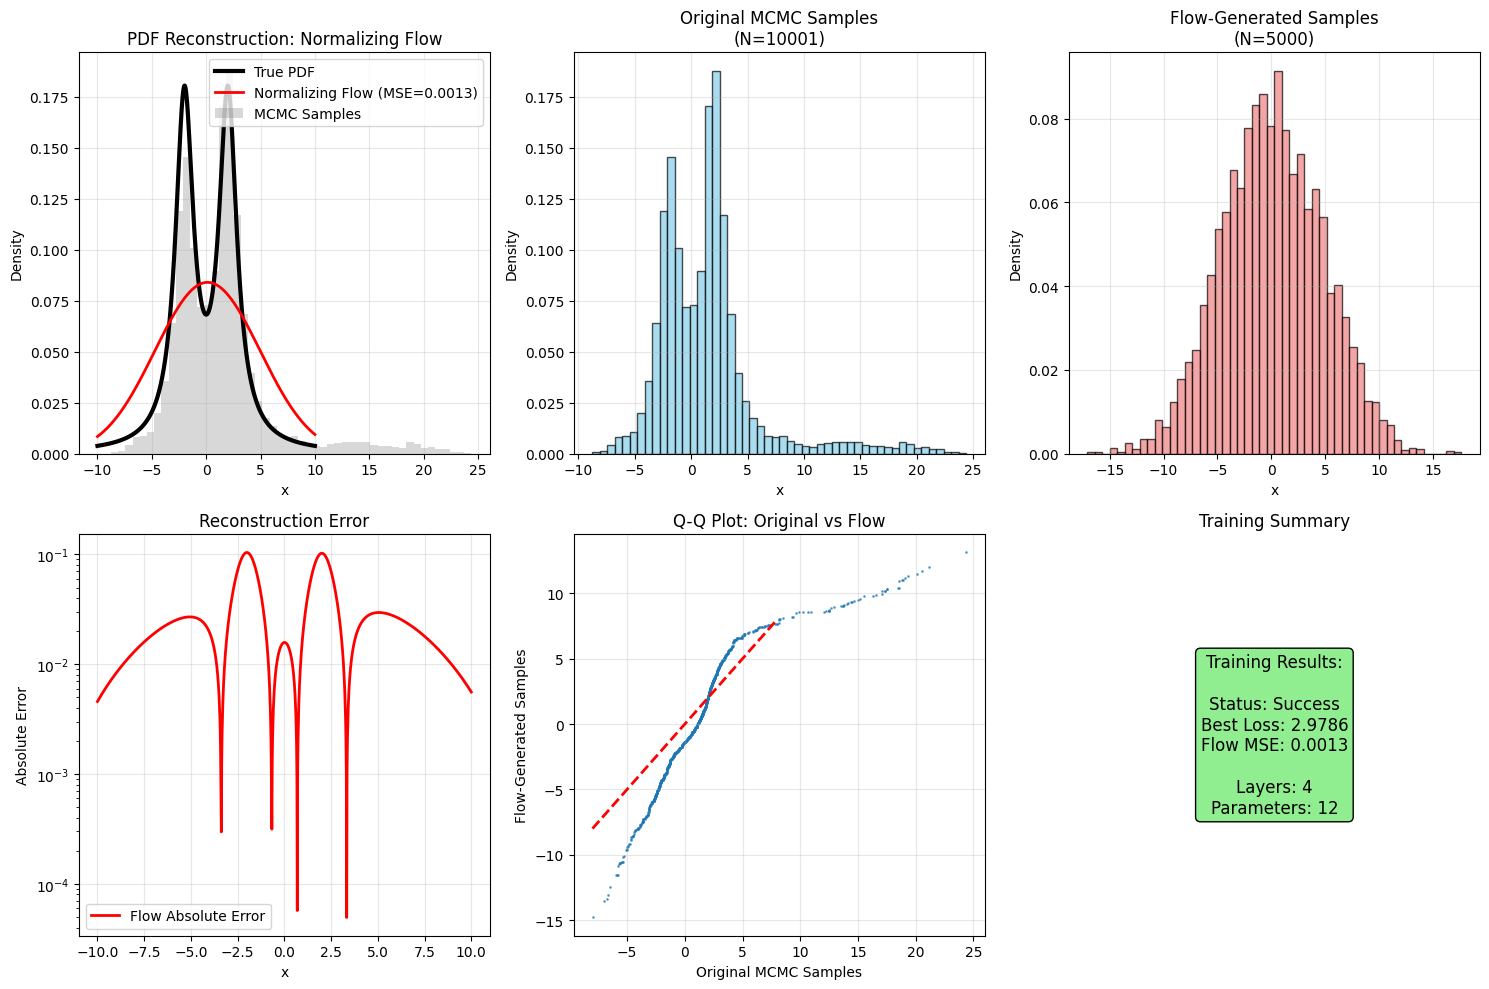


Analysis completed successfully!
Epoch 0, Loss: 2.1058
Epoch 100, Loss: -5.9036
Epoch 200, Loss: -5.5922
Epoch 300, Loss: -6.0371


KeyboardInterrupt: 

In [1]:
# %%
# Install PyTorch if not already installed
%pip install torch

# %%
# Simple Normalizing Flow without PyTorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

print("Running PyTorch-free normalizing flow...")

# ---------- STEP 1: Simulate Markov Chain Samples ----------
# ----- Multimodal Target Distribution -----
def target_pdf(x):
    return 1 / (1 + (x - 2)**2) + 1 / (1 + (x + 2)**2)

def metropolis_sampler(f, N, x0=0.0, step_size=1.0):
    """Metropolis-Hastings sampler"""
    samples = [x0]
    x = x0
    accepted = 0
    
    for i in range(N):
        x_new = x + step_size * np.random.randn()
        alpha = min(1, f(x_new) / f(x))
        if np.random.rand() < alpha:
            x = x_new
            accepted += 1
        samples.append(x)
    
    print(f"MCMC acceptance rate: {accepted/N:.2%}")
    return np.array(samples)

# Generate MCMC samples
np.random.seed(42)
print("Generating MCMC samples...")
samples_np = metropolis_sampler(target_pdf, N=10000, step_size=1.0)
print(f"Generated {len(samples_np)} samples")
print(f"Sample statistics: mean={np.mean(samples_np):.3f}, std={np.std(samples_np):.3f}")

# ---------- STEP 2: Simple Normalizing Flow Implementation ----------
class SimpleNormalizingFlow:
    """Simple 1D normalizing flow using polynomial transformations"""
    
    def __init__(self, n_layers=4):
        self.n_layers = n_layers
        # Initialize parameters: [a, b, c] for each layer
        # f(x) = x + a*tanh(b*x + c)
        self.params = np.random.normal(0, 0.1, (n_layers, 3))
    
    def _layer_forward(self, x, layer_params):
        """Forward pass through one layer"""
        a, b, c = layer_params
        y = x + a * np.tanh(b * x + c)
        # Log determinant of Jacobian
        log_det = np.log(np.abs(1 + a * b * (1 - np.tanh(b * x + c)**2)))
        return y, log_det
    
    def _layer_inverse(self, y, layer_params):
        """Inverse pass through one layer (numerical)"""
        a, b, c = layer_params
        
        def equation(x):
            return x + a * np.tanh(b * x + c) - y
        
        # Newton's method for better convergence
        x = y  # Initial guess
        for _ in range(10):
            fx = equation(x)
            if abs(fx) < 1e-10:
                break
            # Derivative of equation w.r.t. x
            dfx = 1 + a * b * (1 - np.tanh(b * x + c)**2)
            x = x - fx / dfx
        
        log_det = -np.log(np.abs(1 + a * b * (1 - np.tanh(b * x + c)**2)))
        return x, log_det
    
    def forward(self, x):
        """Forward transformation: x -> z"""
        z = x.copy()
        log_det_total = np.zeros_like(x)
        
        for layer_params in self.params:
            z_new = np.zeros_like(z)
            log_det_new = np.zeros_like(z)
            
            for i in range(len(z)):
                z_new[i], log_det_new[i] = self._layer_forward(z[i], layer_params)
            
            z = z_new
            log_det_total += log_det_new
        
        return z, log_det_total
    
    def log_prob(self, x):
        """Compute log probability"""
        z, log_det = self.forward(x)
        # Base distribution is standard normal
        log_prob_base = -0.5 * z**2 - 0.5 * np.log(2 * np.pi)
        return log_prob_base + log_det
    
    def sample(self, n_samples):
        """Sample from the flow"""
        # Sample from base distribution
        z_samples = np.random.normal(0, 1, n_samples)
        
        # Transform through inverse layers
        x_samples = z_samples.copy()
        for layer_params in reversed(self.params):
            x_new = np.zeros_like(x_samples)
            for i in range(len(x_samples)):
                x_new[i], _ = self._layer_inverse(x_samples[i], layer_params)
            x_samples = x_new
        
        return x_samples

# ---------- STEP 3: Train the Flow ----------
def train_flow(flow, samples, n_epochs=3000, learning_rate=0.01):
    """Train normalizing flow using maximum likelihood"""
    
    print("Training normalizing flow...")
    best_loss = float('inf')
    best_params = flow.params.copy()
    
    for epoch in range(n_epochs):
        # Compute negative log likelihood
        try:
            log_probs = flow.log_prob(samples)
            loss = -np.mean(log_probs)
        except:
            loss = 1e6  # Large penalty for invalid parameters
        
        # Save best parameters
        if loss < best_loss:
            best_loss = loss
            best_params = flow.params.copy()
        
        # Simple gradient-free optimization every 25 epochs
        if epoch % 25 == 0:
            def objective(params_flat):
                # Reshape parameters
                flow.params = params_flat.reshape(flow.n_layers, 3)
                try:
                    log_probs = flow.log_prob(samples)
                    if np.any(~np.isfinite(log_probs)):
                        return 1e6
                    return -np.mean(log_probs)
                except:
                    return 1e6  # Large penalty for invalid parameters
            
            # Flatten current parameters
            params_flat = flow.params.flatten()
            
            # Optimize using Nelder-Mead
            result = minimize(objective, params_flat, method='Nelder-Mead',
                            options={'maxiter': 50, 'disp': False})
            
            if result.success and result.fun < best_loss:
                flow.params = result.x.reshape(flow.n_layers, 3)
                best_loss = result.fun
                best_params = flow.params.copy()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {best_loss:.4f}")
    
    # Load best parameters
    flow.params = best_params
    print(f"Training completed! Best loss: {best_loss:.4f}")
    return best_loss


# ---------- STEP 4: Main Analysis ----------
print("Building and training flow...")

# Create and train flow
flow = SimpleNormalizingFlow(n_layers=4)
best_loss = train_flow(flow, samples_np, n_epochs=800)

print("Evaluating trained flow...")

# Evaluation points
x_plot = np.linspace(-10, 10, 1000)

# Flow estimate
try:
    pdf_flow = np.exp(flow.log_prob(x_plot))
    # Generate samples from trained flow
    flow_samples = flow.sample(5000)
    flow_success = True
except:
    print("Warning: Flow evaluation failed, using fallback")
    pdf_flow = np.zeros_like(x_plot)
    flow_samples = np.random.normal(0, 1, 5000)
    flow_success = False

# True PDF (normalized)
true_pdf = target_pdf(x_plot)
true_pdf = true_pdf / np.trapz(true_pdf, x_plot)

# Calculate error
if flow_success:
    mse_flow = np.mean((true_pdf - pdf_flow)**2)
else:
    mse_flow = float('inf')

print(f"\nPDF Reconstruction Results:")
print(f"Flow MSE:  {mse_flow:.6f}" + (" (failed)" if not flow_success else ""))

# Plot results
plt.figure(figsize=(15, 10))

# Main PDF comparison
plt.subplot(2, 3, 1)
plt.plot(x_plot, true_pdf, 'k-', label="True PDF", linewidth=3)
if flow_success:
    plt.plot(x_plot, pdf_flow, 'r-', label=f"Normalizing Flow (MSE={mse_flow:.4f})", linewidth=2)
plt.hist(samples_np, bins=50, density=True, alpha=0.3, color='gray', label='MCMC Samples')
plt.xlabel("x")
plt.ylabel("Density")
plt.title("PDF Reconstruction: Normalizing Flow")
plt.legend()
plt.grid(True, alpha=0.3)

# Original MCMC samples
plt.subplot(2, 3, 2)
plt.hist(samples_np, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel("x")
plt.ylabel("Density")
plt.title(f"Original MCMC Samples\n(N={len(samples_np)})")
plt.grid(True, alpha=0.3)

# Flow-generated samples
plt.subplot(2, 3, 3)
if flow_success:
    plt.hist(flow_samples, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f"Flow-Generated Samples\n(N={len(flow_samples)})")
else:
    plt.text(0.5, 0.5, 'Flow training\nfailed', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Flow Samples (Failed)")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)

# Error plot
plt.subplot(2, 3, 4)
if flow_success:
    error_flow = np.abs(true_pdf - pdf_flow)
    plt.plot(x_plot, error_flow, 'r-', label="Flow Absolute Error", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("Absolute Error")
    plt.title("Reconstruction Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Flow training\nfailed', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Error Plot (Failed)")

# Q-Q plot
plt.subplot(2, 3, 5)
if flow_success:
    n_qq = min(1000, len(samples_np), len(flow_samples))
    sample_subset = np.random.choice(samples_np, n_qq, replace=False)
    flow_subset = np.random.choice(flow_samples, n_qq, replace=False)
    plt.scatter(np.sort(sample_subset), np.sort(flow_subset), alpha=0.6, s=1)
    plt.plot([-8, 8], [-8, 8], 'r--', linewidth=2)
    plt.xlabel("Original MCMC Samples")
    plt.ylabel("Flow-Generated Samples")
    plt.title("Q-Q Plot: Original vs Flow")
else:
    plt.text(0.5, 0.5, 'Flow training\nfailed', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Q-Q Plot (Failed)")
plt.grid(True, alpha=0.3)

# Summary
plt.subplot(2, 3, 6)
status = "Success" if flow_success else "Failed"
plt.text(0.5, 0.5, f'Training Results:\n\n'
                   f'Status: {status}\n'
                   f'Best Loss: {best_loss:.4f}\n'
                   f'Flow MSE: {mse_flow:.4f}\n\n'
                   f'Layers: {flow.n_layers}\n'
                   f'Parameters: {flow.n_layers * 3}',
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen" if flow_success else "lightcoral"))
plt.title("Training Summary")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nAnalysis completed successfully!")

# %% [markdown]
# 

# %%
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----- Device selection -----
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# ----- Generate multimodal data -----
samples = np.concatenate([
    np.random.normal(-2, 0.5, size=5000),
    np.random.normal(2, 0.5, size=5000)
])
x_train = torch.tensor(samples, dtype=torch.float32).unsqueeze(1).to(device)

# ----- Affine Coupling Layer -----
class AffineCoupling(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.s = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.t = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        s = self.s(x)
        t = self.t(x)
        z = x * torch.exp(s) + t
        log_det_jacobian = s
        return z, log_det_jacobian

    def inverse(self, z):
        s = self.s(z)
        t = self.t(z)
        x = (z - t) * torch.exp(-s)
        log_det_jacobian = -s
        return x, log_det_jacobian

# ----- Deep Normalizing Flow -----
class DeepNormalizingFlow(nn.Module):
    def __init__(self, num_layers=4, hidden_dim=16):
        super().__init__()
        self.layers = nn.ModuleList([
            AffineCoupling(hidden_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        log_det_total = torch.zeros_like(x)
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_base = -0.5 * z.pow(2) - 0.5 * torch.log(torch.tensor(2 * torch.pi, device=x.device))
        return (log_base + log_det).squeeze()

# ----- Training Setup -----
batch_size = 512
loader = DataLoader(TensorDataset(x_train), batch_size=batch_size, shuffle=True)

model = DeepNormalizingFlow(num_layers=4, hidden_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----- Training Loop -----
for epoch in range(1000):
    for (batch,) in loader:
        loss = -model.log_prob(batch).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ----- Evaluation -----
x_eval = torch.linspace(-6, 6, 500).unsqueeze(1).to(device)
with torch.no_grad():
    log_pdf = model.log_prob(x_eval)
    pdf = torch.exp(log_pdf)

plt.figure(figsize=(10, 6))
plt.plot(x_eval.cpu().numpy(), pdf.cpu().numpy(), label="Deep Flow Estimate", linewidth=2)
plt.hist(samples, bins=50, density=True, alpha=0.5, label="Target Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Deep 1D Normalizing Flow on Multimodal Data")
plt.grid(True)
plt.show()


# %% [markdown]
# Normalizing Flow PDF Reconstruction

# %%
import numpy as np
import torch
import matplotlib.pyplot as plt

from nflows.flows import Flow
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal

# ---------- STEP 1: Simulate Markov Chain Samples ----------
def target_pdf(x):
    return 1 / (1 + x**2)  # Unnormalized Cauchy-like

def metropolis_sampler(f, N, x0=0.0, step_size=1.0):
    samples = [x0]
    x = x0
    for _ in range(N):
        x_new = x + step_size * np.random.randn()
        alpha = min(1, f(x_new) / f(x))
        if np.random.rand() < alpha:
            x = x_new
        samples.append(x)
    return np.array(samples)

# Generate MCMC samples
np.random.seed(0)
samples_np = metropolis_sampler(target_pdf, N=5000, step_size=1.0)
samples = torch.tensor(samples_np, dtype=torch.float32).unsqueeze(1)  # [N, 1]

# ---------- STEP 2: Build Normalizing Flow ----------
base_dist = StandardNormal(shape=[1])

transform = CompositeTransform([
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
])

flow = Flow(transform, base_dist)

# ---------- STEP 3: Train the Flow ----------
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 1000
batch_size = 256

for epoch in range(epochs):
    idx = torch.randint(0, samples.shape[0], (batch_size,))
    batch = samples[idx]
    log_probs = flow.log_prob(batch)
    loss = -log_probs.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ---------- STEP 4: Evaluate PDF via Normalizing Flow ----------
x_plot = torch.linspace(-10, 10, 1000).unsqueeze(1)
with torch.no_grad():
    log_probs = flow.log_prob(x_plot).numpy()
pdf_flow = np.exp(log_probs)

# ---------- STEP 5: True Normalized PDF for Comparison ----------
x_plot_np = x_plot.squeeze().numpy()
true_pdf = target_pdf(x_plot_np)
true_pdf /= np.trapz(true_pdf, x_plot_np)  # Normalize manually

# ---------- STEP 6: Plot Results ----------
plt.figure(figsize=(10, 6))
plt.plot(x_plot_np, true_pdf, label="True PDF (Cauchy)", linestyle="--")
plt.plot(x_plot_np, pdf_flow, label="Normalizing Flow Estimate", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("PDF Reconstruction: Normalizing Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Normalizing Flow Training with Unknown Target PDF
# We only know f(x) where target_pdf(x) ∝ |f(x)|

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ============================================================================
# EXAMPLE: Unknown target PDF, but we know f(x)
# ============================================================================

# The TRUE target PDF (we pretend we don't know this)
def true_target_pdf(x):
    """Bimodal distribution - we pretend we DON'T know this"""
    return 1 / (1 + (x - 2)**2) + 1 / (1 + (x + 2)**2)

# This is what we ACTUALLY know: a function proportional to the target
def known_function_f(x):
    """This is f(x) where target_pdf ∝ |f(x)|
    In practice, you would replace this with YOUR known function"""
    # For this example, f(x) = true_target_pdf(x) + some noise/scaling
    return 2.5 * (1 / (1 + (x - 2)**2) + 1 / (1 + (x + 2)**2))

# Generate samples using MCMC (using the true PDF)
def metropolis_sampler(f, N, x0=0.0, step_size=1.0):
    """Metropolis-Hastings sampler"""
    samples = [x0]
    x = x0
    accepted = 0
    
    for i in range(N):
        x_new = x + step_size * np.random.randn()
        alpha = min(1, f(x_new) / f(x))
        if np.random.rand() < alpha:
            x = x_new
            accepted += 1
        samples.append(x)
    
    print(f"MCMC acceptance rate: {accepted/N:.2%}")
    return np.array(samples)

# ============================================================================
# NORMALIZING FLOW WITH PROPORTIONALITY CONSTRAINT
# ============================================================================

device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

class AffineCoupling(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.s = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.t = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        s = self.s(x)
        t = self.t(x)
        z = x * torch.exp(s) + t
        log_det_jacobian = s
        return z, log_det_jacobian

class NormalizingFlowWithConstraint(nn.Module):
    def __init__(self, num_layers=6, hidden_dim=32):
        super().__init__()
        self.layers = nn.ModuleList([
            AffineCoupling(hidden_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        log_det_total = torch.zeros_like(x)
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_base = -0.5 * z.pow(2) - 0.5 * torch.log(torch.tensor(2 * torch.pi, device=x.device))
        return (log_base + log_det).squeeze()
    
    def prob(self, x):
        """Return probability (not log)"""
        return torch.exp(self.log_prob(x))

# ============================================================================
# CUSTOM LOSS FUNCTION
# ============================================================================

def combined_loss(model, batch, f_func, lambda_nll=1.0, lambda_var=10.0):
    """
    Combined loss function:
    1. Negative log-likelihood (standard flow training)
    2. Variance of |f(x)| / p(x) ratio (proportionality constraint)
    
    Args:
        model: Normalizing flow model
        batch: Batch of samples
        f_func: Known function f(x) where target ∝ |f(x)|
        lambda_nll: Weight for NLL loss
        lambda_var: Weight for variance loss
    """
    
    # Loss 1: Standard negative log-likelihood
    log_probs = model.log_prob(batch)
    nll_loss = -log_probs.mean()
    
    # Loss 2: Minimize variance of |f(x)| / p(x)
    with torch.no_grad():
        f_values = torch.tensor([f_func(x.item()) for x in batch], 
                                device=batch.device, dtype=batch.dtype).unsqueeze(1)
    
    # Get flow probabilities
    flow_probs = model.prob(batch)
    
    # Compute ratio: |f(x)| / p_flow(x)
    ratios = torch.abs(f_values.squeeze()) / (flow_probs + 1e-8)  # Small epsilon for stability
    
    # Minimize variance of ratios (they should all be the same constant C)
    variance_loss = torch.var(ratios)
    
    # Also minimize coefficient of variation for scale invariance
    mean_ratio = torch.mean(ratios)
    cv_loss = torch.sqrt(variance_loss) / (mean_ratio + 1e-8)
    
    # Combined loss
    total_loss = lambda_nll * nll_loss + lambda_var * cv_loss
    
    return total_loss, nll_loss, variance_loss, cv_loss, mean_ratio

# ============================================================================
# TRAINING
# ============================================================================

# Generate samples
np.random.seed(42)
print("Generating MCMC samples from true distribution...")
samples_np = metropolis_sampler(true_target_pdf, N=10000, step_size=1.0)
samples = torch.tensor(samples_np, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Sample statistics: mean={samples_np.mean():.3f}, std={samples_np.std():.3f}")

# Create model
model = NormalizingFlowWithConstraint(num_layers=6, hidden_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Training parameters
batch_size = 256
n_epochs = 2000
lambda_nll = 1.0      # Weight for standard NLL
lambda_var = 5.0      # Weight for variance constraint

loader = DataLoader(TensorDataset(samples), batch_size=batch_size, shuffle=True)

print(f"\nTraining with constraint: |f(x)| / p(x) = constant")
print(f"Lambda NLL: {lambda_nll}, Lambda Variance: {lambda_var}")
print("-" * 70)

# Training loop
history = {'total_loss': [], 'nll': [], 'variance': [], 'cv': [], 'mean_ratio': []}

for epoch in range(n_epochs):
    epoch_losses = {'total': [], 'nll': [], 'var': [], 'cv': [], 'ratio': []}
    
    for (batch,) in loader:
        total_loss, nll, var_loss, cv, mean_ratio = combined_loss(
            model, batch, known_function_f, lambda_nll, lambda_var
        )
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_losses['total'].append(total_loss.item())
        epoch_losses['nll'].append(nll.item())
        epoch_losses['var'].append(var_loss.item())
        epoch_losses['cv'].append(cv.item())
        epoch_losses['ratio'].append(mean_ratio.item())
    
    # Record epoch averages
    history['total_loss'].append(np.mean(epoch_losses['total']))
    history['nll'].append(np.mean(epoch_losses['nll']))
    history['variance'].append(np.mean(epoch_losses['var']))
    history['cv'].append(np.mean(epoch_losses['cv']))
    history['mean_ratio'].append(np.mean(epoch_losses['ratio']))
    
    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:4d} | Loss: {history['total_loss'][-1]:.4f} | "
              f"NLL: {history['nll'][-1]:.4f} | CV: {history['cv'][-1]:.4f} | "
              f"Mean Ratio: {history['mean_ratio'][-1]:.4f}")

print("\nTraining completed!")

# ============================================================================
# EVALUATION AND VISUALIZATION
# ============================================================================

print("\nEvaluating model...")

# Evaluation points
x_eval = torch.linspace(-8, 8, 1000).unsqueeze(1).to(device)

with torch.no_grad():
    # Flow PDF
    log_pdf_flow = model.log_prob(x_eval)
    pdf_flow = torch.exp(log_pdf_flow).cpu().numpy()
    
    # Known function f(x)
    f_values = np.array([known_function_f(x.item()) for x in x_eval.cpu()])
    
    # True target PDF (for comparison - in practice we wouldn't know this)
    true_pdf = np.array([true_target_pdf(x.item()) for x in x_eval.cpu()])
    
    # Normalize for comparison
    x_eval_np = x_eval.cpu().numpy().squeeze()
    pdf_flow_norm = pdf_flow / np.trapz(pdf_flow, x_eval_np)
    f_values_norm = np.abs(f_values) / np.trapz(np.abs(f_values), x_eval_np)
    true_pdf_norm = true_pdf / np.trapz(true_pdf, x_eval_np)
    
    # Compute ratios to check proportionality
    ratios = np.abs(f_values) / (pdf_flow + 1e-8)

print(f"\nRatio statistics (|f(x)| / p_flow(x)):")
print(f"  Mean: {np.mean(ratios):.4f}")
print(f"  Std:  {np.std(ratios):.4f}")
print(f"  CV:   {np.std(ratios)/np.mean(ratios):.4f} (Coefficient of Variation)")
print(f"\n  Ideally, CV should be close to 0 (constant ratio)")

# ============================================================================
# PLOTTING
# ============================================================================

fig = plt.figure(figsize=(16, 12))

# 1. PDF Comparison
ax1 = plt.subplot(3, 3, 1)
plt.plot(x_eval_np, true_pdf_norm, 'k-', label='True PDF (unknown)', linewidth=2, alpha=0.7)
plt.plot(x_eval_np, pdf_flow_norm, 'r-', label='Flow PDF', linewidth=2)
plt.plot(x_eval_np, f_values_norm, 'b--', label='|f(x)| normalized', linewidth=2, alpha=0.7)
plt.hist(samples_np, bins=50, density=True, alpha=0.3, color='gray', label='MCMC Samples')
plt.xlabel('x', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('PDF Reconstruction', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 2. Ratio |f(x)| / p_flow(x) - Should be constant!
ax2 = plt.subplot(3, 3, 2)
plt.plot(x_eval_np, ratios, 'g-', linewidth=2, label='|f(x)| / p_flow(x)')
plt.axhline(y=np.mean(ratios), color='r', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(ratios):.2f}')
plt.fill_between(x_eval_np, 
                 np.mean(ratios) - np.std(ratios), 
                 np.mean(ratios) + np.std(ratios), 
                 alpha=0.3, color='red', label=f'±1 std')
plt.xlabel('x', fontsize=11)
plt.ylabel('Ratio', fontsize=11)
plt.title(f'Proportionality Check (CV={np.std(ratios)/np.mean(ratios):.4f})', 
          fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 3. Error: Flow vs True PDF
ax3 = plt.subplot(3, 3, 3)
error = np.abs(pdf_flow_norm - true_pdf_norm)
plt.plot(x_eval_np, error, 'purple', linewidth=2)
plt.xlabel('x', fontsize=11)
plt.ylabel('Absolute Error', fontsize=11)
plt.title(f'Reconstruction Error (MSE={np.mean(error**2):.6f})', 
          fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 4. Training Loss
ax4 = plt.subplot(3, 3, 4)
plt.plot(history['total_loss'], label='Total Loss', linewidth=2)
plt.plot(history['nll'], label='NLL Loss', linewidth=2, alpha=0.7)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('Training Loss', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 5. Coefficient of Variation (CV) over training
ax5 = plt.subplot(3, 3, 5)
plt.plot(history['cv'], 'orange', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Coefficient of Variation', fontsize=11)
plt.title('CV of Ratio (Lower = Better)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 6. Mean Ratio over training
ax6 = plt.subplot(3, 3, 6)
plt.plot(history['mean_ratio'], 'brown', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Mean Ratio', fontsize=11)
plt.title('Mean of |f(x)| / p(x) (Finding C)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 7. Histogram of ratios
ax7 = plt.subplot(3, 3, 7)
plt.hist(ratios, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=np.mean(ratios), color='r', linestyle='--', linewidth=2, 
            label=f'Mean={np.mean(ratios):.2f}')
plt.xlabel('|f(x)| / p_flow(x)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Distribution of Ratios', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 8. Sample comparison
ax8 = plt.subplot(3, 3, 8)
plt.hist(samples_np, bins=50, density=True, alpha=0.5, color='blue', 
         edgecolor='black', label='Original MCMC')
# Generate new samples from flow
with torch.no_grad():
    z_samples = torch.randn(5000, 1).to(device)
    # Need to implement inverse - for now just show original
plt.xlabel('x', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Sample Distribution', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 9. Summary statistics
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""
TRAINING SUMMARY
{'='*40}

Final Metrics:
  • Total Loss:     {history['total_loss'][-1]:.4f}
  • NLL Loss:       {history['nll'][-1]:.4f}
  • CV (ratio):     {history['cv'][-1]:.4f}
  • Mean Ratio (C): {history['mean_ratio'][-1]:.4f}

Ratio Statistics:
  • Mean:  {np.mean(ratios):.4f}
  • Std:   {np.std(ratios):.4f}
  • CV:    {np.std(ratios)/np.mean(ratios):.4f}
  • Min:   {np.min(ratios):.4f}
  • Max:   {np.max(ratios):.4f}

Model Configuration:
  • Layers:     {model.layers.__len__()}
  • Hidden dim: 32
  • λ_NLL:      {lambda_nll}
  • λ_Var:      {lambda_var}
  
Reconstruction MSE: {np.mean(error**2):.6f}
"""
ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION GUIDE:")
print("="*70)
print("The flow learned p(x) such that |f(x)| / p(x) ≈ constant")
print(f"The constant C ≈ {np.mean(ratios):.4f}")
print(f"\nTherefore: p(x) ≈ |f(x)| / {np.mean(ratios):.4f}")
print("\nThe lower the CV (Coefficient of Variation), the better the fit!")
print("="*70)

Using device: mps
Generating MCMC samples from true distribution...
MCMC acceptance rate: 81.68%
Sample statistics: mean=1.335, std=4.445

Training with constraint: |f(x)| / p(x) = constant
Lambda NLL: 1.0, Lambda Variance: 5.0
----------------------------------------------------------------------
Epoch    0 | Loss: 22.5585 | NLL: 9.8850 | CV: 2.5347 | Mean Ratio: 21347991.3438
